In [1]:
import numpy as np 
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import importlib

import sys
sys.path.append('../util/')
import reader
import composites
importlib.reload(reader)

from tqdm import tqdm, notebook
import xarray as xr

In [3]:
# reading in the matlab files for era-interim
folder = '/localdrive/drive10/jj/mdtf/wkdir/MDTF_ERAI.EXP1.TEST.001_2008_2012/etc_composites/tmp/RUNDIR/tmprun/read_tmprun/'
print(os.path.exists(folder))

# reading in a sample model data
mdtf_folder = '/localdrive/drive10/jj/mdtf/wkdir/MDTF_GFDL.EXP1.2PM.001_2008_2012/etc_composites/tmp/RUNDIR/tmprun/read_tmprun/'
print(os.path.exists(mdtf_folder))

# Reading in the topography file
lm_file = '/localdrive/drive10/jj/mdtf/inputdata/model/ERAI.EXP1.TEST.001/topo.nc'
print(os.path.exists(lm_file))

True
True
True


In [7]:
importlib.reload(reader)

years = [2008, 2012]
erai_lat = []
erai_lon = []
erai_mm = []

# reading in ll of ERA-Interim data
for year in range(years[0], years[1]+1):
    file = os.path.join(folder, f"tmprun_{year}.mat")
    all_centers = reader.read_center_from_mat_file(file)
    lat = all_centers['lat']
    lon = all_centers['lon']
    mm = all_centers['mm']
    ind = (np.abs(lat) > 30) & (np.abs(lat) < 60)
    lat = lat[ind]
    lon = lon[ind]
    erai_lat.extend(lat)
    erai_lon.extend(lon)
    erai_mm.extend(mm)
    
    print(f"Done processing {year}.")

# reading in a single year of MODEL data
years = [2008, 2008]
mdtf_lat = []
mdtf_lon = []
mdtf_mm = []
for year in range(years[0], years[1]+1):
    file = os.path.join(mdtf_folder, f"tmprun_{year}.mat")
    all_centers = reader.read_center_from_mat_file(file)
    lat = all_centers['lat']
    lon = all_centers['lon']
    mm = all_centers['mm']
    ind = (np.abs(lat) > 30) & (np.abs(lat) < 60)
    lat = lat[ind]
    lon = lon[ind]
    mdtf_lat.extend(lat)
    mdtf_lon.extend(lon)
    mdtf_mm.extend(mm)
    print(f"Done processing {year}.")

Done processing 2008.
Done processing 2009.
Done processing 2010.
Done processing 2011.
Done processing 2012.
Done processing 2008.


In [13]:
slp_file = '/localdrive/drive10/jj/mdtf/wkdir/MDTF_ERAI.EXP1.TEST.001_2008_2012/etc_composites/tmp/data_converts/slp.2008.nc'
slp = xr.open_dataset(slp_file)
reflat = slp.lat.values
reflon = slp.lon.values

reflon, reflat = np.meshgrid(reflon, reflat)

ds = xr.open_dataset(lm_file)
lm = ds.lsm.isel(time=0).values
lm = (lm > 50./100.)

In [22]:
# print(ds.longitude.values)
print(slp.lat.values)

[ 90.   88.5  87.   85.5  84.   82.5  81.   79.5  78.   76.5  75.   73.5
  72.   70.5  69.   67.5  66.   64.5  63.   61.5  60.   58.5  57.   55.5
  54.   52.5  51.   49.5  48.   46.5  45.   43.5  42.   40.5  39.   37.5
  36.   34.5  33.   31.5  30.   28.5  27.   25.5  24.   22.5  21.   19.5
  18.   16.5  15.   13.5  12.   10.5   9.    7.5   6.    4.5   3.    1.5
   0.   -1.5  -3.   -4.5  -6.   -7.5  -9.  -10.5 -12.  -13.5 -15.  -16.5
 -18.  -19.5 -21.  -22.5 -24.  -25.5 -27.  -28.5 -30.  -31.5 -33.  -34.5
 -36.  -37.5 -39.  -40.5 -42.  -43.5 -45.  -46.5 -48.  -49.5 -51.  -52.5
 -54.  -55.5 -57.  -58.5 -60.  -61.5 -63.  -64.5 -66.  -67.5 -69.  -70.5
 -72.  -73.5 -75.  -76.5 -78.  -79.5 -81.  -82.5 -84.  -85.5 -87.  -88.5
 -90. ]


In [10]:
erai_obs_lat = []
erai_obs_lon = []

# filtering out the lat/lon for the SH Ocean Warm season, and creating the observation distribution
for ilat, ilon, imm in notebook.tqdm(zip(erai_lat, erai_lon, erai_mm), total=len(erai_lat)):
    # skipping northern hemisphere distribution
    if (ilat > 0): 
        continue
       
    # checking warm season
    if not ((imm == 11) | (imm == 12) | (imm == 1) | (imm == 2) | (imm == 3)):
        continue
        
    # checking ocean (=0), skip if land (=1)
    dist_grid = composites.compute_dist_from_cdt(reflat, reflon, ilat, ilon)
    c_ind = np.nanargmin(dist_grid)
    cx, cy = np.unravel_index(c_ind, dist_grid.shape)
    lm_flag = lm[cx, cy]
    
    if (lm_flag):
        continue
        
    erai_obs_lat.append(ilat)
    erai_obs_lon.append(ilon)
    
    
erai_obs_lat = np.array(erai_obs_lat) 
erai_obs_lon = np.array(erai_obs_lon) 

In [11]:
print(erai_obs_lat.shape)
print(erai_obs_lon.shape)

(16229,)
(16229,)


In [12]:
# ERAI disbribution for the observations (entire collection of cyclones)
bins = np.arange(-60, 60, 5)
erai_lat_ind = np.digitize(erai_lat, bins=bins)
erai_lat_bin_counts = np.bincount(erai_lat_ind, minlength=len(bins))
erai_pct = erai_lat_bin_counts/np.sum(erai_lat_bin_counts)
erai_pct[erai_lat_bin_counts == 0] = np.nan

# ERAI disbribution for the observations(SH Ocean Warm)
erai_obs_lat_ind = np.digitize(erai_obs_lat, bins=bins)
erai_obs_lat_bin_counts = np.bincount(erai_obs_lat_ind, minlength=len(bins))
erai_obs_pct = erai_obs_lat_bin_counts/np.sum(erai_obs_lat_bin_counts)
erai_obs_pct[erai_obs_lat_bin_counts == 0] = np.nan

# MDTF distribution of cyclones
mdtf_lat_ind = np.digitize(mdtf_lat, bins=bins)
mdtf_lat_bin_counts = np.bincount(mdtf_lat_ind, minlength=len(bins))
mdtf_pct = mdtf_lat_bin_counts/np.sum(mdtf_lat_bin_counts)
mdtf_pct[mdtf_lat_bin_counts == 0] = np.nan

print(erai_lat_bin_counts)
print(erai_obs_lat_bin_counts)
print(mdtf_lat_bin_counts)

[    0 10716  6979  5906  5493  4971  3996     0     0     0     0     0
     0     0     0     0     0     0     0  3305  4325  5526  6734  8545
 10378]
[   0 4738 3027 2514 2436 1998 1516    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[   0 2040 1460 1097 1061  881  589    0    0    0    0    0    0    0
    0    0    0    0    0  474  741 1115 1401 1689 1869]


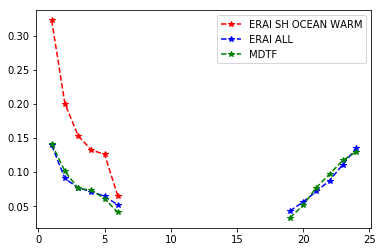

In [205]:
plt.plot(erai_obs_pct, 'r*--', label='ERAI SH OCEAN WARM')
plt.plot(erai_pct, 'b*--', label='ERAI ALL')
plt.plot(mdtf_pct, 'g*--', label='MDTF')
plt.legend(loc=0)
plt.show()

19 0.0328778525352015 474 11025.196974281393


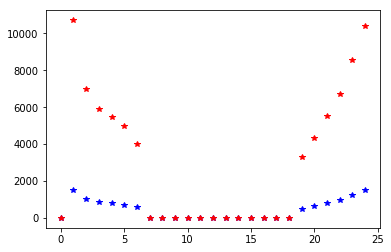

In [206]:
# Selecting all the MDTF cases by the total_distrib
mdtf_min_ind = np.nanargmin(mdtf_pct)
mdtf_min = mdtf_pct[mdtf_min_ind]
mdtf_min_count = mdtf_lat_bin_counts[mdtf_min_ind]
erai_min_pct = erai_pct[mdtf_min_ind]

total_mdtf_count = mdtf_min_count/erai_min_pct
print(mdtf_min_ind, mdtf_min, mdtf_min_count, total_mdtf_count)

new_distrib = erai_pct * total_mdtf_count
new_distrib[np.isnan(new_distrib)] = 0
new_distrib = np.array(new_distrib, dtype=np.int)

# print(erai_lat_bin_counts)
# print(mdtf_lat_bin_counts)
# print(new_distrib)

plt.plot(new_distrib, 'b*')
plt.plot(erai_lat_bin_counts, 'r*')

19 0.0328778525352015 474 nan
[   0 1111  690  528  456  434  224    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[   0 2040 1460 1097 1061  881  589    0    0    0    0    0    0    0
    0    0    0    0    0  474  741 1115 1401 1689 1869]
[   0 1536 1000  847  787  712  573    0    0    0    0    0    0    0
    0    0    0    0    0  474  620  792  965 1225 1488]


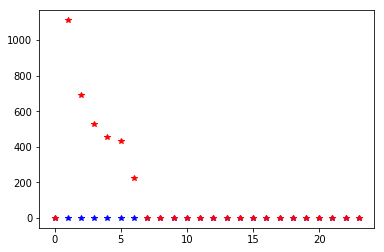

In [207]:
# Selecting all the MDTF cases by the total_distrib
mdtf_min_ind = np.nanargmin(mdtf_pct)
mdtf_min = mdtf_pct[mdtf_min_ind]
mdtf_min_count = mdtf_lat_bin_counts[mdtf_min_ind]
erai_obs_min_pct = erai_obs_pct[mdtf_min_ind]

total_mdtf_count = mdtf_min_count/erai_obs_min_pct
print(mdtf_min_ind, mdtf_min, mdtf_min_count, total_mdtf_count)

new_obs_distrib = erai_obs_pct * total_mdtf_count
new_obs_distrib[np.isnan(new_obs_distrib)] = 0
new_obs_distrib = np.array(new_obs_distrib, dtype=np.int)

print(erai_obs_lat_bin_counts)
print(mdtf_lat_bin_counts)
print(new_distrib)

plt.plot(new_obs_distrib, 'b*')
plt.plot(erai_obs_lat_bin_counts, 'r*')
plt.show()

# Saving the ERAI information cyclone distribution, I have to match this to the model 

In [209]:
out = {'all_lat_ind': erai_lat_ind, 'all_bin_counts': erai_lat_bin_counts, 'all_pct': erai_pct,
       'obs_lat_ind': erai_obs_lat_ind, 'obs_bin_counts': erai_obs_lat_bin_counts, 'obs_pct': erai_obs_pct}
out_file = '/localdrive/drive10/jj/mdtf/inputdata/obs_data/etc_composites/erai_lat_distrib.pkl'

# Some online method to sub-sample datasets

In [93]:
weights = 1 / np.array([lat_bin_counts[x] for x in lat_ind])
# weights_norm = weights / np.sum(weights)

mdtf_weights = 1 / np.array([lat_bin_counts[x] for x in mdtf_lat_ind])
# mdtf_weights_norm = mdtf_weights / np.sum(mdtf_weights)

In [94]:
np.random.seed(0)
SAMPLE_SIZE = len(mdtf_lat)
sample = np.random.choice(mdtf_lat, size=SAMPLE_SIZE, p=mdtf_weights_norm, replace=False)

In [97]:
sample_lat_ind = np.digitize(sample, bins=np.arange(-60, 60, 5))
sample_lat_bin_counts = np.bincount(sample_lat_ind)
sample_lat_bin_counts = sample_lat_bin_counts/np.sum(sample_lat_bin_counts)

In [98]:

print(lat_bin_counts, mdtf_lat_bin_counts, sample_lat_bin_counts)

[0.         0.13939694 0.09078492 0.07682702 0.07145459 0.06466426
 0.05198116 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.04299243 0.05626089 0.07188386 0.08759789 0.11115592
 0.13500013] [0.         0.15769997 0.1104198  0.08719992 0.07550188 0.05900533
 0.04235967 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.02613422 0.04877123 0.07246554 0.08661706 0.11028425
 0.12354113] [0.         0.15769997 0.1104198  0.08719992 0.07550188 0.05900533
 0.04235967 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.02613422 0.04877123 0.07246554 0.08661706 0.11028425
 0.12354113]


(array([20306., 12900.,  4855.,     0.,     0.,     0.,     0.,  4153.,
        12678., 21982.]),
 array([-5.9980e+01, -4.7983e+01, -3.5986e+01, -2.3989e+01, -1.1992e+01,
         5.0000e-03,  1.2002e+01,  2.3999e+01,  3.5996e+01,  4.7993e+01,
         5.9990e+01]),
 <a list of 10 Patch objects>)

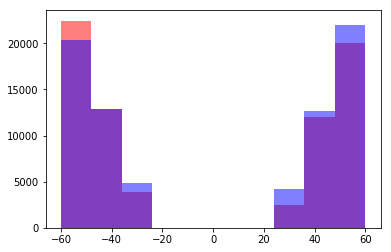

In [81]:
plt.hist(sample, color='r', alpha=0.5)
plt.hist(all_lat, color='b', alpha=0.5)

15212 73773


(array([0.02592136, 0.01392225, 0.00393395, 0.        , 0.        ,
        0.        , 0.        , 0.0027724 , 0.01428387, 0.02251339]),
 array([-59.99 , -47.992, -35.994, -23.996, -11.998,   0.   ,  11.998,
         23.996,  35.994,  47.992,  59.99 ]),
 <a list of 10 Patch objects>)

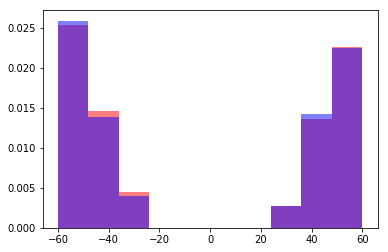

In [71]:
print(len(lat), len(mdtf_lat))
plt.hist(mdtf_lat, density=True, color='r', alpha=0.5)
plt.hist(lat, density=True, color='b', alpha=0.5)

In [66]:
np.random.seed(0)
SAMPLE_SIZE = len(mdtf_lat)
sample = np.random.choice(mdtf_lat, size=SAMPLE_SIZE, p=weights_norm, replace=False)

ValueError: 'a' and 'p' must have same size